In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Maximum Likelihood Estimation (MLE) and Maximum a Posteriori (MAP)

In [77]:
# Load training and test sets
train_data = pd.read_csv('poly_regression_small.csv')
test_data = pd.read_csv('poly_regression_large.csv')

X_train, y_train = train_data['x'].values, train_data['y'].values
X_test, y_test = test_data['x'].values, test_data['y'].values

np.random.seed(42)
indices = np.random.permutation(X_test.shape[0])
split = int(0.2 * X_test.shape[0])
X_test, y_test = X_test[indices[:split]], y_test[indices[:split]]

def polynomial_features(x, k):
    x_poly = np.zeros((x.shape[0], k))
    for i in range(k):
        x_poly[:, i] = x**i
    return x_poly

In [78]:
def GD(loss, grad_loss, D, theta0, max_iterations, tolf, tolx, sigma, lambda_=None):
    X, y = D
    d = theta0.shape[0]
    
    theta_history = []
    loss_history = []
    grad_norm_history = []
    
    theta = theta0
    if lambda_:
        initial_grad_norm = np.linalg.norm(grad_loss(X, y, theta, sigma, lambda_))
    else:
        initial_grad_norm = np.linalg.norm(grad_loss(X, y, theta, sigma))
    
    for it in range(max_iterations):
        if lambda_:
            grad = grad_loss(X, y, theta, sigma, lambda_)
        else:
            grad = grad_loss(X, y, theta, sigma)
        
        if np.linalg.norm(grad) < tolf * initial_grad_norm:
            break
        
        t = 1
        tau = 0.25
        c = 0.5
        if lambda_:
            while loss(X, y, theta - t * grad, sigma, lambda_) > loss(X, y, theta, sigma, lambda_) - c * t * np.linalg.norm(grad)**2:
                t *= tau
        else:
            while loss(X, y, theta - t * grad, sigma) > loss(X, y, theta, sigma) - c * t * np.linalg.norm(grad)**2:
                t *= tau

        theta_new = theta - t * grad
        
        if np.linalg.norm(theta_new - theta) < tolx:
            theta = theta_new
            theta_history.append(theta)
            if lambda_:
                loss_history.append(loss(X, y, theta, sigma, lambda_))
            else:
                loss_history.append(loss(X, y, theta, sigma))
            grad_norm_history.append(np.linalg.norm(grad))
            break

        theta = theta_new
        theta_history.append(theta)
        if lambda_:
            loss_history.append(loss(X, y, theta, sigma, lambda_))
        else:
            loss_history.append(loss(X, y, theta, sigma))
        grad_norm_history.append(np.linalg.norm(grad))
    
    return np.array(theta_history), np.array(loss_history), np.array(grad_norm_history)

def SGD(loss, grad_loss, D, theta0, alpha, batch_size, n_epochs, sigma, lambda_=None):
    X, y = D  # Unpack the data
    N = X.shape[0] # We assume both X and Y has shape (N, )
    d = theta0.shape[0] # While theta0 has shape (d, )
    idx = np.arange(0, N) # This is required for the shuffling
    
    # Initialization of history vectors
    theta_history = np.zeros((n_epochs, d))  # Save parameters at each epoch
    loss_history = np.zeros((n_epochs, ))  # Save loss values at each epoch
    grad_norm_history = np.zeros((n_epochs, ))  # Save gradient norms at each epoch
    
    # Initialize weights
    theta = theta0
    for epoch in range(n_epochs):
        # Shuffle the data at the beginning of each epoch
        np.random.shuffle(idx)
        X = X[idx]
        y = y[idx]

        # Initialize a vector that saves the gradient of the loss at each iteration
        grad_loss_vec = []

        for batch_start in range(0, N, batch_size):
            batch_end = min(batch_start + batch_size, N)
            X_batch = X[batch_start:batch_end]
            y_batch = y[batch_start:batch_end]
            
            # Compute the gradient of the loss
            if lambda_:
                gradient = grad_loss(X_batch, y_batch, theta, sigma, lambda_)
            else:
                gradient = grad_loss(X_batch, y_batch, theta, sigma)
            
            grad_loss_vec.append(np.linalg.norm(gradient, 2))

            # Update weights
            theta = theta - alpha * gradient

        # Save the updated values
        theta_history[epoch] = theta
        if lambda_:
            loss_history[epoch] = loss(X, y, theta, sigma, lambda_)
        else:
            loss_history[epoch] = loss(X, y, theta, sigma)
        grad_norm_history[epoch] = np.mean(grad_loss_vec)
    
    return theta_history, loss_history, grad_norm_history

def mle_with_cholesky(Phi, Y):
    A = Phi.T @ Phi
    b = Phi.T @ Y
    
    L = np.linalg.cholesky(A)
    z = np.linalg.solve(L, b)
    
    theta_MLE = np.linalg.solve(L.T, z)
    
    return theta_MLE


In [79]:
# 1 Compute MLE estimates
K = 5
sigma = np.std(y_train)

X_train_poly = polynomial_features(X_train, K)

def fun_MLE(X, y, theta, sigma):
    return (1/(2*sigma)) * (np.linalg.norm(X @ theta - y)**2)

def grad_fun_MLE(X, y, theta, sigma):
    return (1/sigma) * (X.T @ (X @ theta - y))

theta0 = np.zeros(K)

max_iterations = 1000
tolf = 1e-5
tolx = 1e-5

learning_rate = 0.01
batch_size = 10
n_epochs = 1000

theta_history_GD, loss_history_GD, grad_norm_history_GD = GD(fun_MLE, grad_fun_MLE, (X_train_poly, y_train), theta0, max_iterations, tolf, tolx, sigma)
theta_GD = theta_history_GD[-1]
theta_history_SGD, loss_history_SGD, grad_norm_history_SGD = SGD(fun_MLE, grad_fun_MLE, (X_train_poly, y_train), theta0, learning_rate, batch_size, n_epochs, sigma)
theta_SGD = theta_history_SGD[-1]
theta_CH = mle_with_cholesky(X_train_poly, y_train)

Gradient Descent Error: 0.010669710598732349
Stochastic Gradient Descent Error: 0.011181932479064285
Normal Equations Error: 0.009570856108518742


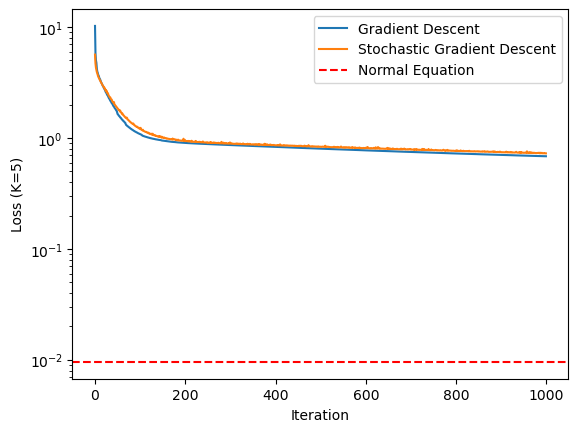

In [80]:
# 2 Compare the performance of the three methods
X_test_poly = polynomial_features(X_test, K)

def calculate_error(y_pred, y_true):
    return np.mean((y_true - y_pred) ** 2)

err_gd = calculate_error(X_test_poly @ theta_GD, y_test)
err_sgd = calculate_error(X_test_poly @ theta_SGD, y_test)
err_ne = calculate_error(X_test_poly @ theta_CH, y_test)

print(f"Gradient Descent Error: {err_gd}")
print(f"Stochastic Gradient Descent Error: {err_sgd}")
print(f"Normal Equations Error: {err_ne}")

plt.figure()
plt.semilogy(loss_history_GD, label="Gradient Descent")
plt.semilogy(loss_history_SGD, label="Stochastic Gradient Descent")
plt.axhline(y=err_ne, color='r', linestyle='--', label=f"Normal Equation")
plt.xlabel("Iteration")
plt.ylabel(f"Loss (K={K})")
plt.legend()
plt.show()


From the results, we can observe that normal gradient descent and stochastic gradient descent perform similarly, whereas normal equations result in significantly lower error

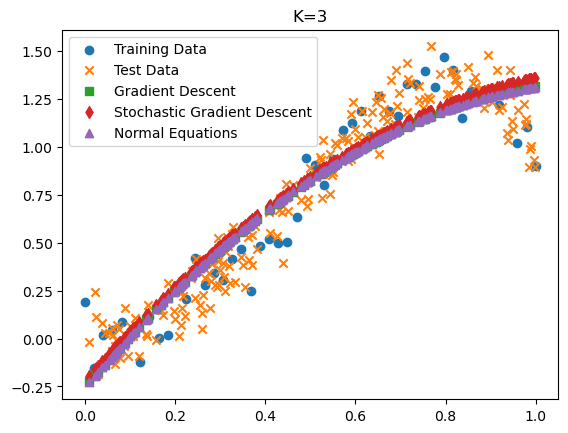

K=3
MSE Gradient Descent Error: 0.02273978522119385
MSE Stochastic Gradient Descent Error: 0.023474657106896047
MSE Normal Equations Error: 0.02265812041834752


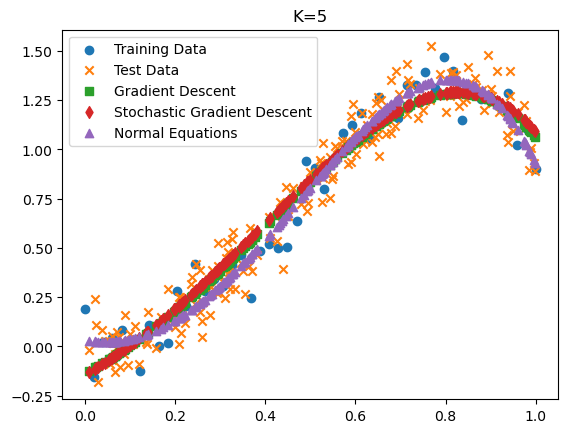

K=5
MSE Gradient Descent Error: 0.010669710598732349
MSE Stochastic Gradient Descent Error: 0.011207733085284104
MSE Normal Equations Error: 0.009570856108518742


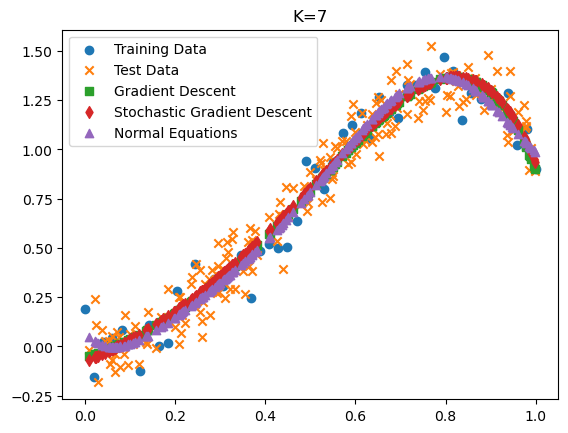

K=7
MSE Gradient Descent Error: 0.009430742850624646
MSE Stochastic Gradient Descent Error: 0.009362941859241095
MSE Normal Equations Error: 0.009883827658184595


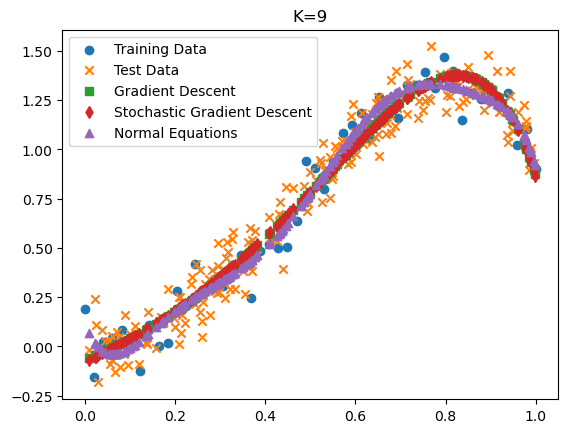

K=9
MSE Gradient Descent Error: 0.009706523234834384
MSE Stochastic Gradient Descent Error: 0.009808335059399938
MSE Normal Equations Error: 0.01002070552291924


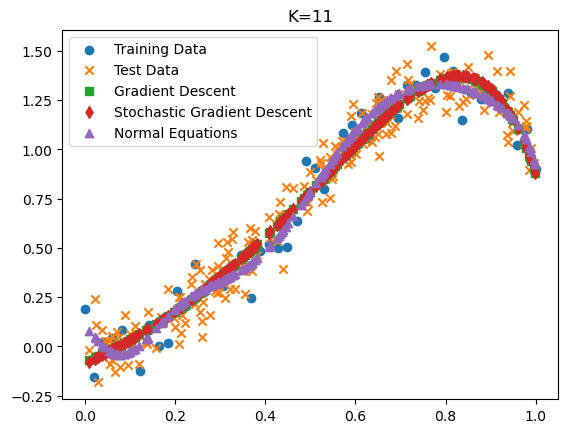

K=11
MSE Gradient Descent Error: 0.009650660725958311
MSE Stochastic Gradient Descent Error: 0.009757239117041072
MSE Normal Equations Error: 0.010090155386710849


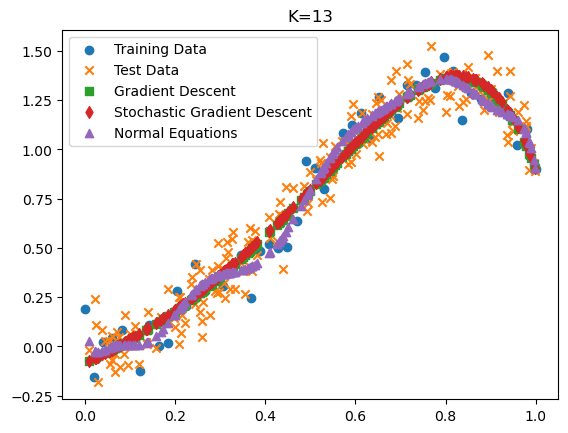

K=13
MSE Gradient Descent Error: 0.009514729953889746
MSE Stochastic Gradient Descent Error: 0.009594469787718473
MSE Normal Equations Error: 0.010533167058018515


In [81]:
# 3 Plot training and test data for different K
degrees = [3, 5, 7, 9, 11, 13]
for K in degrees:
    theta0 = np.zeros(K)
    
    X_train_poly = polynomial_features(X_train, K)
    X_test_poly = polynomial_features(X_test, K)
    
    theta_history_GD, loss_history_GD, grad_norm_history_GD = GD(fun_MLE, grad_fun_MLE, (X_train_poly, y_train), theta0, max_iterations, tolf, tolx, sigma)
    theta_GD = theta_history_GD[-1]
    theta_history_SGD, loss_history_SGD, grad_norm_history_SGD = SGD(fun_MLE, grad_fun_MLE, (X_train_poly, y_train), theta0, learning_rate, batch_size, n_epochs, sigma)
    theta_SGD = theta_history_SGD[-1]
    theta_CH = mle_with_cholesky(X_train_poly, y_train)
    
    y_pred_gd = X_test_poly @ theta_GD
    y_pred_sgd = X_test_poly @ theta_SGD
    y_pred_ne = X_test_poly @ theta_CH
    plt.scatter(X_train, y_train, label='Training Data', marker='o')
    plt.scatter(X_test, y_test, label='Test Data', marker='x')
    plt.scatter(X_test, y_pred_gd, label='Gradient Descent', marker='s')
    plt.scatter(X_test, y_pred_sgd, label='Stochastic Gradient Descent', marker='d')
    plt.scatter(X_test, y_pred_ne, label='Normal Equations', marker='^')
    plt.title(f"K={K}")
    plt.legend()
    plt.show()
    
    # Evaluate the error
    err_gd = calculate_error(y_pred_gd, y_test)
    err_sgd = calculate_error(y_pred_sgd, y_test)
    err_ne = calculate_error(y_pred_ne, y_test)
    print(f"K={K}")
    print(f"MSE Gradient Descent Error: {err_gd}")
    print(f"MSE Stochastic Gradient Descent Error: {err_sgd}")
    print(f"MSE Normal Equations Error: {err_ne}")

From the results we can see how by increasing K, the generated functions of GD and SGD doesn't change much, while the NE function starts shaking, meaning an overfitting effect

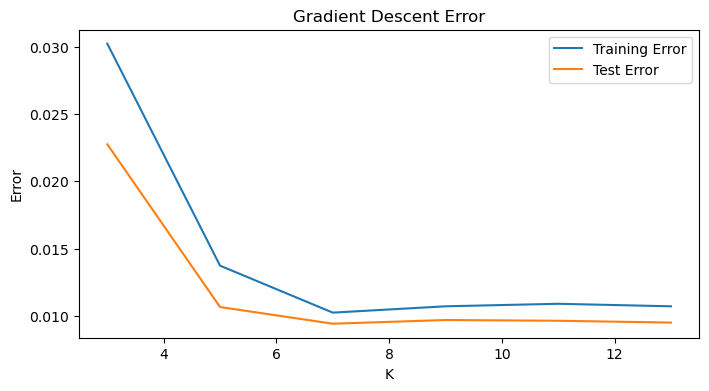

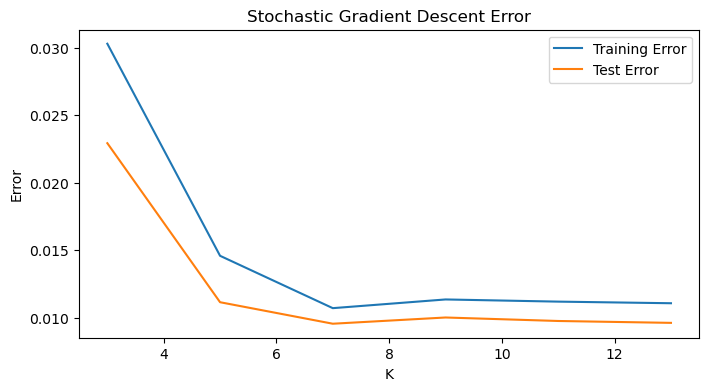

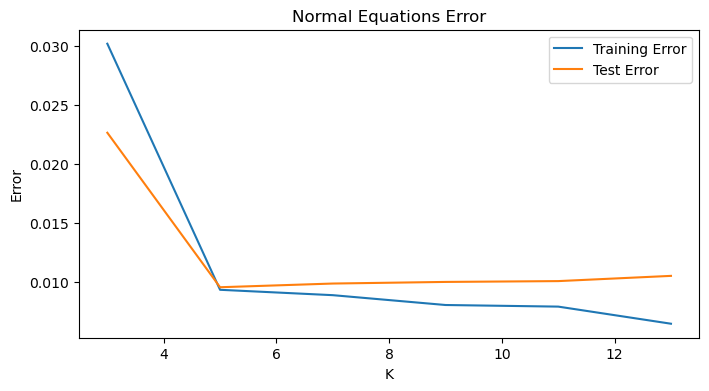

In [82]:
# 4. Evaluate the performance of the three methods for different K
train_errors_gd = []
test_errors_gd = []
train_error_sgd = []
test_errors_sgd = []
train_error_ne = []
test_errors_ne = []

for K in degrees:
    X_train_poly = polynomial_features(X_train, K)
    X_test_poly = polynomial_features(X_test, K)
    theta0 = np.zeros(K)
    
    theta_history_GD, loss_history_GD, grad_norm_history_GD = GD(fun_MLE, grad_fun_MLE, (X_train_poly, y_train), theta0, max_iterations, tolf, tolx, sigma)
    theta_GD = theta_history_GD[-1]
    theta_history_SGD, loss_history_SGD, grad_norm_history_SGD = SGD(fun_MLE, grad_fun_MLE, (X_train_poly, y_train), theta0, learning_rate, batch_size, n_epochs, sigma)
    theta_SGD = theta_history_SGD[-1]
    theta_CH = mle_with_cholesky(X_train_poly, y_train)
        
    pred_train_gd = X_train_poly @ theta_GD
    pred_test_gd = X_test_poly @ theta_GD
    
    pred_train_sgd = X_train_poly @ theta_SGD
    pred_test_sgd = X_test_poly @ theta_SGD
    
    pred_train_ne = X_train_poly @ theta_CH
    pred_test_ne = X_test_poly @ theta_CH
        
    train_errors_gd.append(calculate_error(pred_train_gd, y_train))
    test_errors_gd.append(calculate_error(pred_test_gd, y_test))
    
    train_error_sgd.append(calculate_error(pred_train_sgd, y_train))
    test_errors_sgd.append(calculate_error(pred_test_sgd, y_test))
    
    train_error_ne.append(calculate_error(pred_train_ne, y_train))
    test_errors_ne.append(calculate_error(pred_test_ne, y_test))

def plot_errors(train_errors, test_errors, method):
    plt.figure(figsize=(8, 4))
    plt.plot(degrees, train_errors, label='Training Error')
    plt.plot(degrees, test_errors, label='Test Error')
    plt.xlabel('K')
    plt.ylabel('Error')
    plt.title(f'{method} Error')
    plt.legend()
    plt.show()
    
plot_errors(train_errors_gd, test_errors_gd, 'Gradient Descent')
plot_errors(train_error_sgd, test_errors_sgd, 'Stochastic Gradient Descent')
plot_errors(train_error_ne, test_errors_ne, 'Normal Equations')

The plots reveal that all three methods produce similar results and trends for this task, however, while the test error is consistently lower than the training error in both GD and SGD, the normal equations with K=5 exhibit a different behavior: the training error drops below the test error, indicating potential overfitting

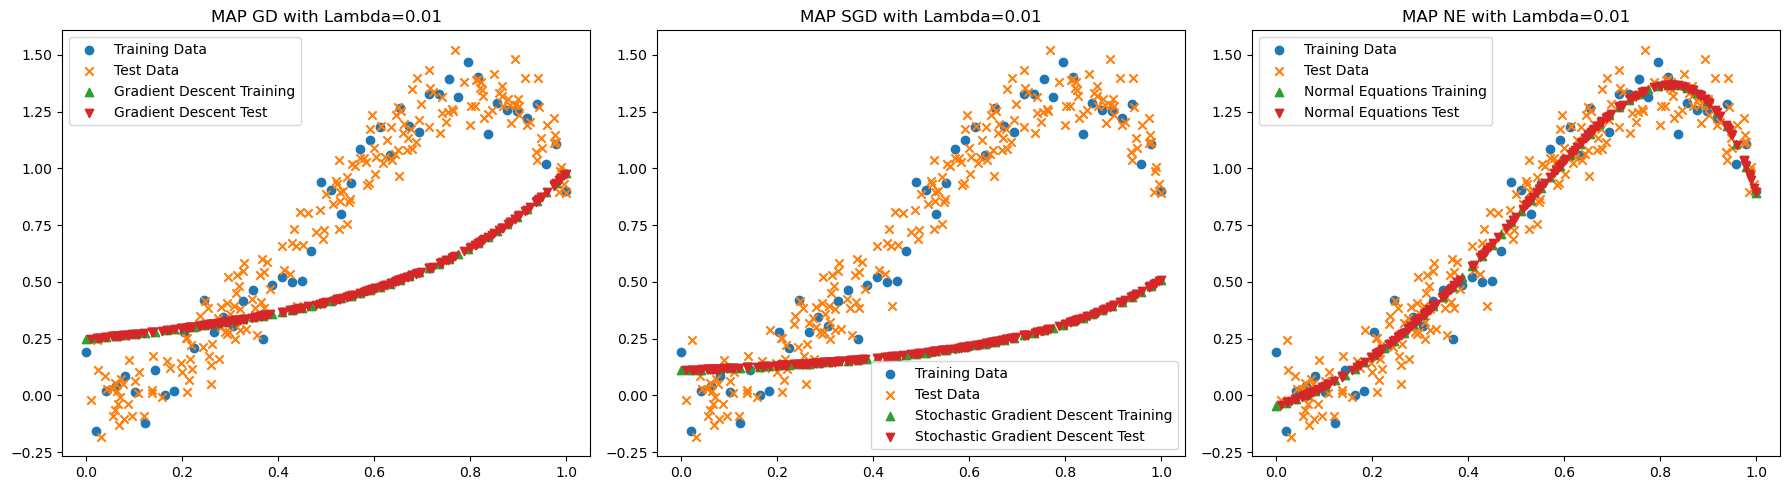

Lambda: 0.01
  GD   - Training Error: 0.1945, Test Error: 0.1911
  SGD  - Training Error: 0.4295, Test Error: 0.4331
  NE   - Training Error: 0.0102, Test Error: 0.0095


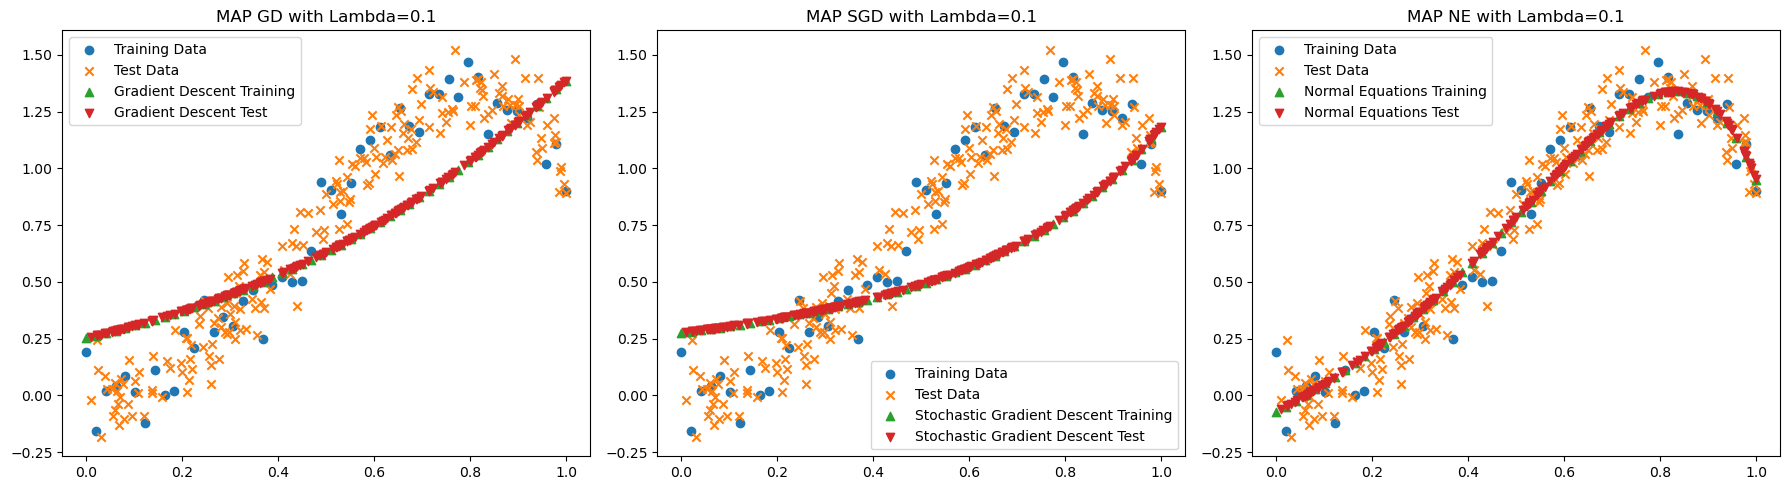

Lambda: 0.1
  GD   - Training Error: 0.0728, Test Error: 0.0658
  SGD  - Training Error: 0.1374, Test Error: 0.1319
  NE   - Training Error: 0.0116, Test Error: 0.0097


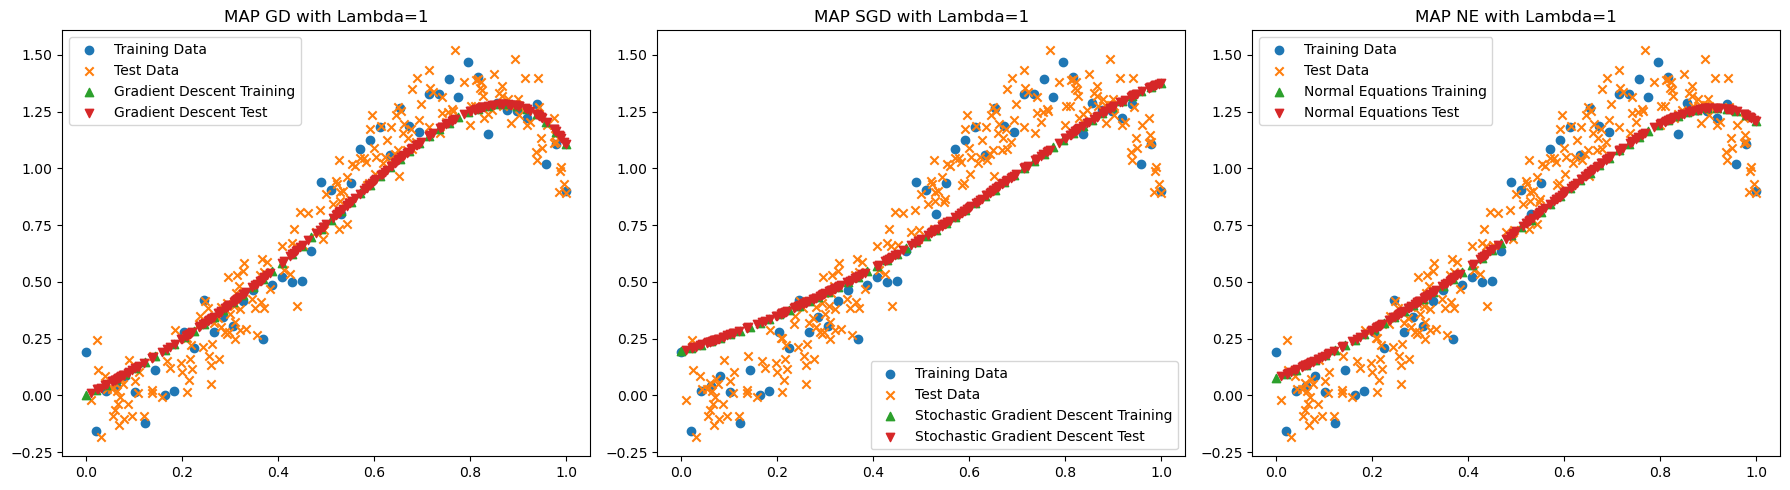

Lambda: 1
  GD   - Training Error: 0.0185, Test Error: 0.0153
  SGD  - Training Error: 0.0510, Test Error: 0.0448
  NE   - Training Error: 0.0286, Test Error: 0.0244


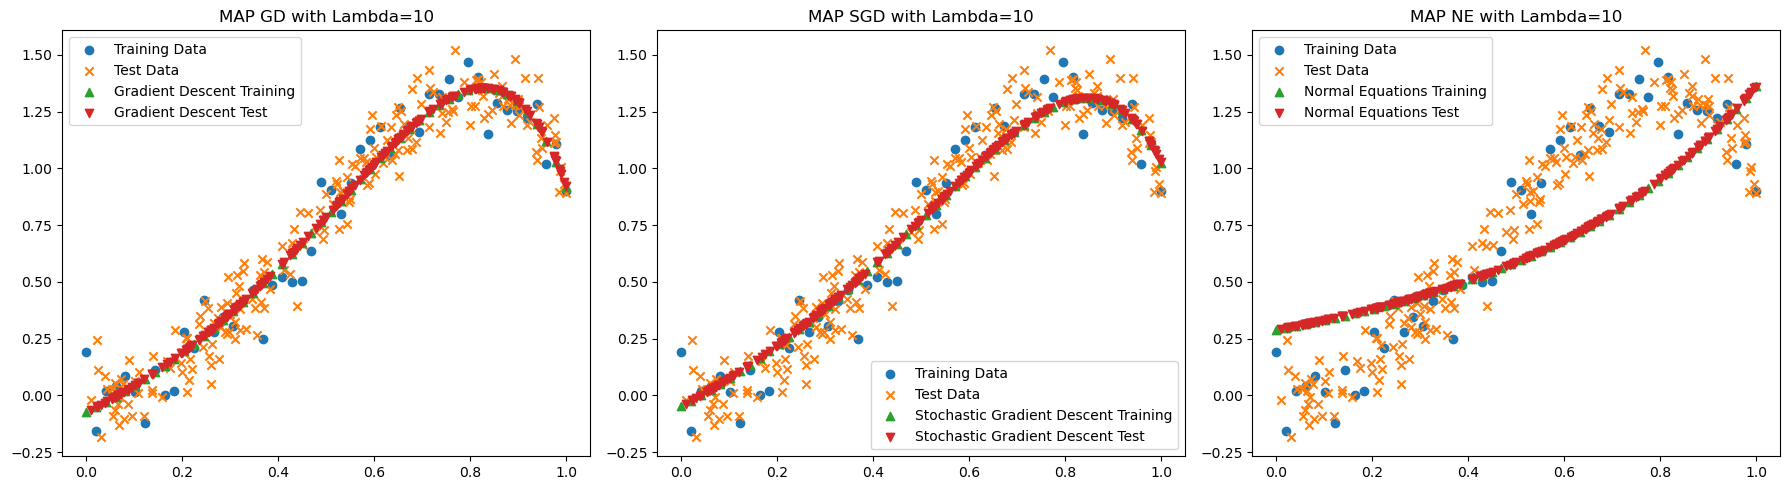

Lambda: 10
  GD   - Training Error: 0.0110, Test Error: 0.0095
  SGD  - Training Error: 0.0137, Test Error: 0.0112
  NE   - Training Error: 0.0936, Test Error: 0.0863


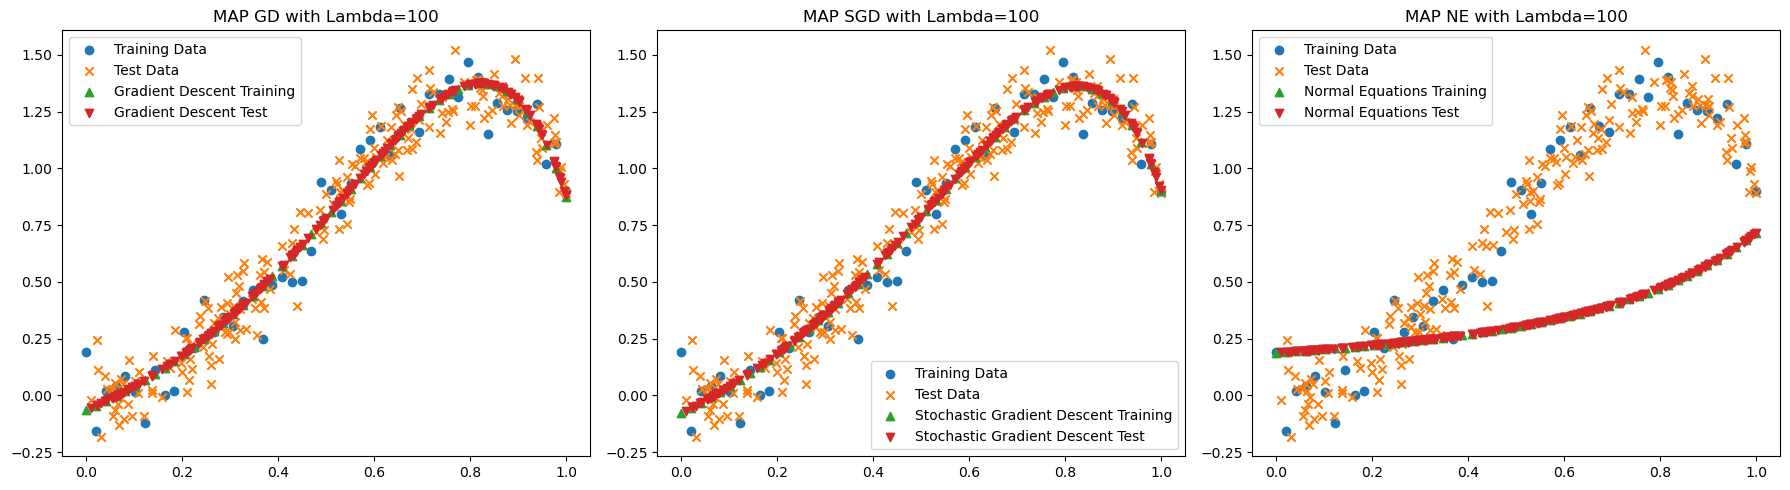

Lambda: 100
  GD   - Training Error: 0.0106, Test Error: 0.0096
  SGD  - Training Error: 0.0109, Test Error: 0.0095
  NE   - Training Error: 0.2990, Test Error: 0.2990


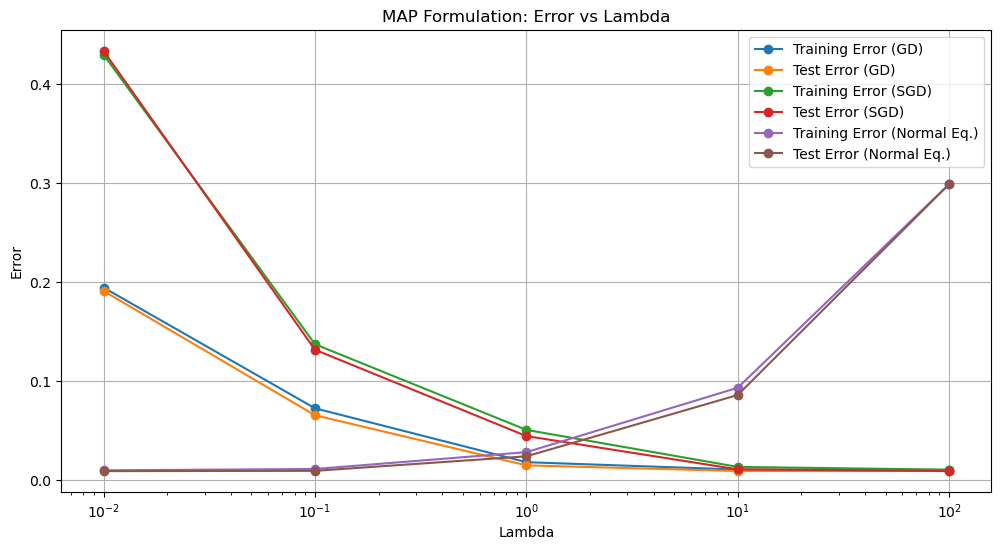

In [83]:
# 5. Repeat the experiments with MAP formulation with Gaussian assumption
def func_MAP(X, y, theta, sigma, lambda_):
    return (1/(2*sigma)) * (np.linalg.norm(X @ theta - y)**2) + (1/(2*lambda_)) * (np.linalg.norm(theta)**2)

def grad_func_MAP(X, y, theta, sigma, lambda_):
    return (1/sigma) * (X.T @ (X @ theta - y)) + (1/lambda_) * theta

def map_with_cholesky(phi_X, Y, lambda_):
    n_features = phi_X.shape[1]
    A = phi_X.T @ phi_X + lambda_ * np.eye(n_features)    
    L = np.linalg.cholesky(A)    
    z = np.linalg.solve(L, phi_X.T @ Y)
    
    theta_map = np.linalg.solve(L.T, z)
    
    return theta_map

K = 8
lambdas = [0.01, 0.1, 1, 10, 100]

train_errors_gd = []
test_errors_gd = []
train_errors_sgd = []
test_errors_sgd = []
train_errors_ne = []
test_errors_ne = []

for lambda_ in lambdas:
    X_train_poly = polynomial_features(X_train, K)
    X_test_poly = polynomial_features(X_test, K)

    theta0 = np.zeros(K)
    
    theta_history_gd, loss_history_gd, grad_norm_history_gd = GD(func_MAP, grad_func_MAP, (X_train_poly, y_train), theta0, max_iterations, tolf, tolx, sigma, lambda_)
    theta_gd = theta_history_gd[-1]
    theta_history_sgd, loss_history_sgd, grad_norm_history_sgd = SGD(func_MAP, grad_func_MAP, (X_train_poly, y_train), theta0, learning_rate, batch_size, n_epochs, sigma, lambda_)
    theta_sgd = theta_history_sgd[-1]
    theta_ne = map_with_cholesky(X_train_poly, y_train, lambda_)

    pred_train_gd = X_train_poly @ theta_gd
    pred_test_gd = X_test_poly @ theta_gd
    train_error_gd = calculate_error(pred_train_gd, y_train)
    test_error_gd = calculate_error(pred_test_gd, y_test)
    test_errors_gd.append(test_error_gd)
    train_errors_gd.append(train_error_gd)
    
    pred_train_sgd = X_train_poly @ theta_sgd
    pred_test_sgd = X_test_poly @ theta_sgd
    train_error_sgd = calculate_error(pred_train_sgd, y_train)
    test_error_sgd = calculate_error(pred_test_sgd, y_test)
    test_errors_sgd.append(test_error_sgd)
    train_errors_sgd.append(train_error_sgd)
    
    pred_train_ne = X_train_poly @ theta_ne
    pred_test_ne = X_test_poly @ theta_ne
    train_error_ne = calculate_error(pred_train_ne, y_train)
    test_error_ne = calculate_error(pred_test_ne, y_test)
    test_errors_ne.append(test_error_ne)
    train_errors_ne.append(train_error_ne)

    # Consolidate plots into a single row
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].scatter(X_train, y_train, label='Training Data', marker='o')
    axes[0].scatter(X_test, y_test, label='Test Data', marker='x')
    axes[0].scatter(X_train, pred_train_gd, label='Gradient Descent Training', marker='^')
    axes[0].scatter(X_test, pred_test_gd, label='Gradient Descent Test', marker='v')
    axes[0].set_title(f"MAP GD with Lambda={lambda_}")
    axes[0].legend()

    axes[1].scatter(X_train, y_train, label='Training Data', marker='o')
    axes[1].scatter(X_test, y_test, label='Test Data', marker='x')
    axes[1].scatter(X_train, pred_train_sgd, label='Stochastic Gradient Descent Training', marker='^')
    axes[1].scatter(X_test, pred_test_sgd, label='Stochastic Gradient Descent Test', marker='v')
    axes[1].set_title(f"MAP SGD with Lambda={lambda_}")
    axes[1].legend()

    axes[2].scatter(X_train, y_train, label='Training Data', marker='o')
    axes[2].scatter(X_test, y_test, label='Test Data', marker='x')
    axes[2].scatter(X_train, pred_train_ne, label='Normal Equations Training', marker='^')
    axes[2].scatter(X_test, pred_test_ne, label='Normal Equations Test', marker='v')
    axes[2].set_title(f"MAP NE with Lambda={lambda_}")
    axes[2].legend()

    plt.tight_layout()
    plt.show()

    print(f"Lambda: {lambda_}")
    print(f"  GD   - Training Error: {train_error_gd:.4f}, Test Error: {test_error_gd:.4f}")
    print(f"  SGD  - Training Error: {train_error_sgd:.4f}, Test Error: {test_error_sgd:.4f}")
    print(f"  NE   - Training Error: {train_error_ne:.4f}, Test Error: {test_error_ne:.4f}")

plt.figure(figsize=(12, 6))
plt.plot(lambdas, train_errors_gd, label='Training Error (GD)', marker='o')
plt.plot(lambdas, test_errors_gd, label='Test Error (GD)', marker='o')
plt.plot(lambdas, train_errors_sgd, label='Training Error (SGD)', marker='o')
plt.plot(lambdas, test_errors_sgd, label='Test Error (SGD)', marker='o')
plt.plot(lambdas, train_errors_ne, label='Training Error (Normal Eq.)', marker='o')
plt.plot(lambdas, test_errors_ne, label='Test Error (Normal Eq.)', marker='o')
plt.xlabel('Lambda')
plt.ylabel('Error')
plt.xscale('log')
plt.title('MAP Formulation: Error vs Lambda')
plt.legend()
plt.grid()
plt.show()

From the results, we observe that with lower regularization, both Gradient Descent and Stochastic Gradient Descent exhibit high error in their outcomes, whereas the Normal Equation fits the data very well, however, as the regularization factor increases, the Normal Equation loses a significant amount of precision, while GD and SGD improve in accuracy.

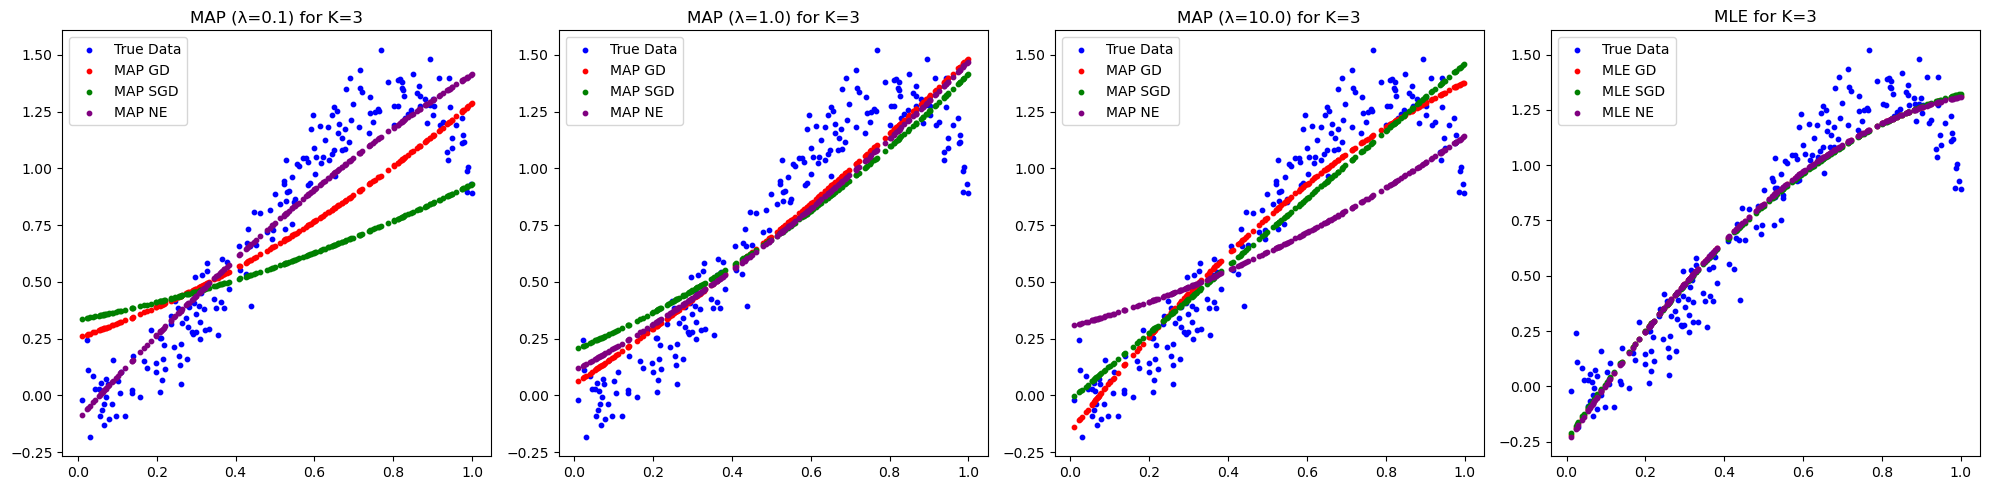

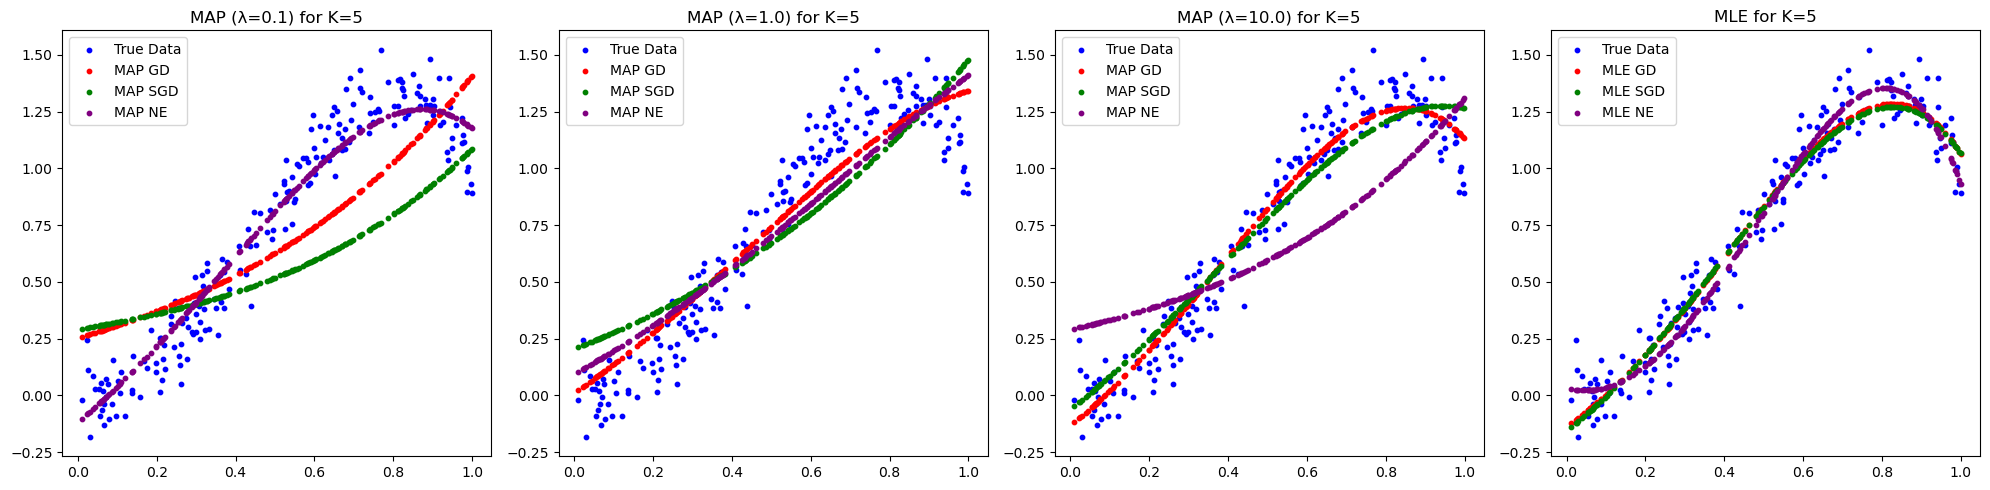

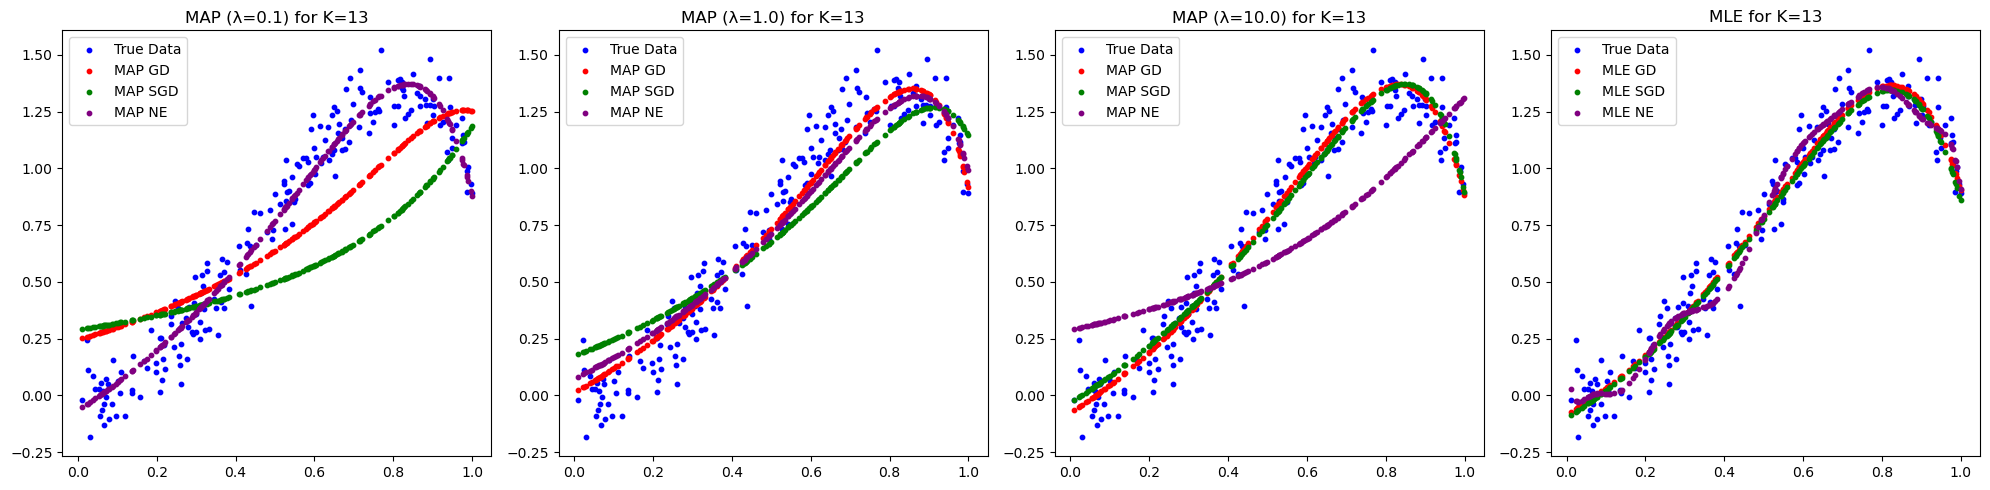

In [84]:
# MLE vs MAP
Ks = [3, 5, 13]
lambdas = [0.1, 1.0, 10.0]


for K in Ks:
    X_train_poly = polynomial_features(X_train, K)
    X_test_poly = polynomial_features(X_test, K)
    theta0 = np.zeros(K)

    # MLE estimation
    theta_history_GD, _, _ = GD(fun_MLE, grad_fun_MLE, (X_train_poly, y_train), theta0, max_iterations, tolf, tolx, sigma)
    theta_mle_GD = theta_history_GD[-1]
    theta_history_SGD, _, _ = SGD(fun_MLE, grad_fun_MLE, (X_train_poly, y_train), theta0, learning_rate, batch_size, n_epochs, sigma)
    theta_mle_SGD = theta_history_SGD[-1]
    theta_mle_NE = mle_with_cholesky(X_train_poly, y_train)

    pred_test_mle_GD = X_test_poly @ theta_mle_GD
    pred_test_mle_SGD = X_test_poly @ theta_mle_SGD
    pred_test_mle_NE = X_test_poly @ theta_mle_NE

    # MAP estimation for different lambdas
    map_evaluations = []

    for lambda_ in lambdas:
        theta_history_GD, _, _ = GD(func_MAP, grad_func_MAP, (X_train_poly, y_train), theta0, max_iterations, tolf, tolx, sigma, lambda_)
        theta_map_GD = theta_history_GD[-1]
        theta_history_SGD, _, _ = SGD(func_MAP, grad_func_MAP, (X_train_poly, y_train), theta0, learning_rate, batch_size, n_epochs, sigma, lambda_)
        theta_map_SGD = theta_history_SGD[-1]
        theta_map_NE = map_with_cholesky(X_train_poly, y_train, lambda_)

        single_map_evaluation = [
            X_test_poly @ theta_map_GD,
            X_test_poly @ theta_map_SGD,
            X_test_poly @ theta_map_NE
        ]

        map_evaluations.append(single_map_evaluation)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    for idx, lambda_ in enumerate(lambdas):
        axes[idx].scatter(X_test, y_test, label='True Data', color='blue', s=10)
        axes[idx].scatter(X_test, map_evaluations[idx][0], label='MAP GD', color='red', s=10)
        axes[idx].scatter(X_test, map_evaluations[idx][1], label='MAP SGD', color='green', s=10)
        axes[idx].scatter(X_test, map_evaluations[idx][2], label='MAP NE', color='purple', s=10)
        axes[idx].set_title(f"MAP (λ={lambda_}) for K={K}")
        axes[idx].legend()

    axes[-1].scatter(X_test, y_test, label='True Data', color='blue', s=10)
    axes[-1].scatter(X_test, pred_test_mle_GD, label='MLE GD', color='red', s=10)
    axes[-1].scatter(X_test, pred_test_mle_SGD, label='MLE SGD', color='green', s=10)
    axes[-1].scatter(X_test, pred_test_mle_NE, label='MLE NE', color='purple', s=10)
    axes[-1].set_title(f"MLE for K={K}")
    axes[-1].legend()

    plt.tight_layout()
    plt.show()